In [1]:
#imports
from torchvision import transforms
from matplotlib import pyplot as plt
from get_loader import get_loader
from model import CNN2RNN, ImageCaptioner
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
from utils import print_examples
import torch
import torch.nn as nn

In [2]:
transform_train = transforms.Compose(
        [
            transforms.Resize((356,356)),
            transforms.RandomCrop((299,299)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]
    )

In [3]:
train_loader, train_dataset = get_loader(
        train_folder = "./data/flickr8k/Images",
        annotation_file_train = "./data/flickr8k/captions.txt",
        transform_train = transform_train,
        num_workers = 2,
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


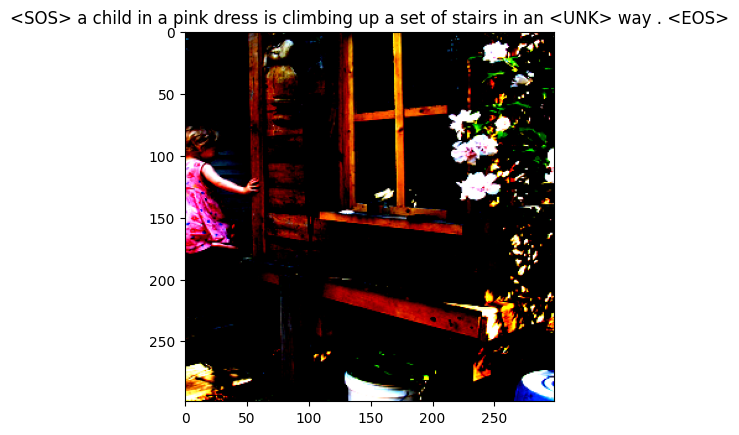

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


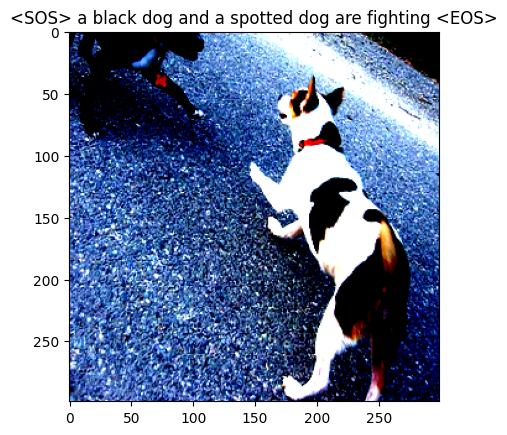

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


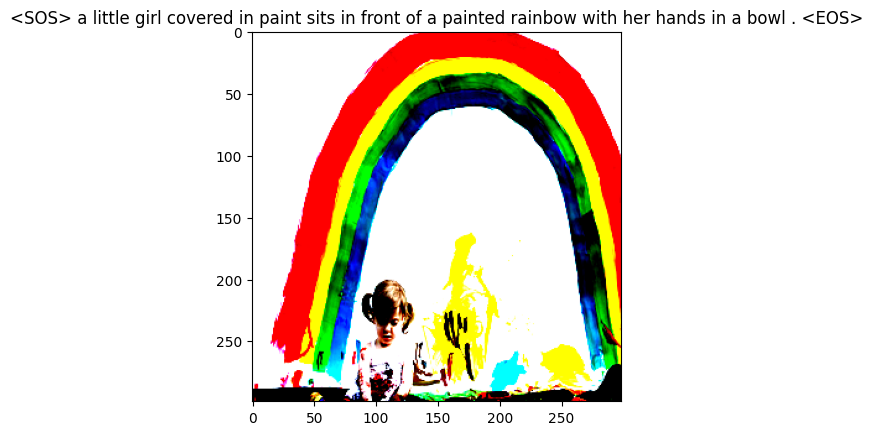

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


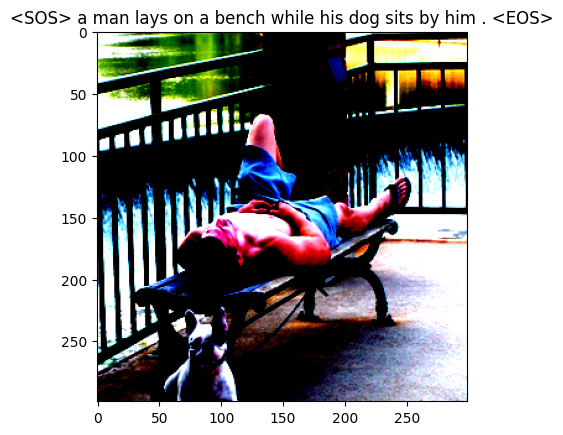

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


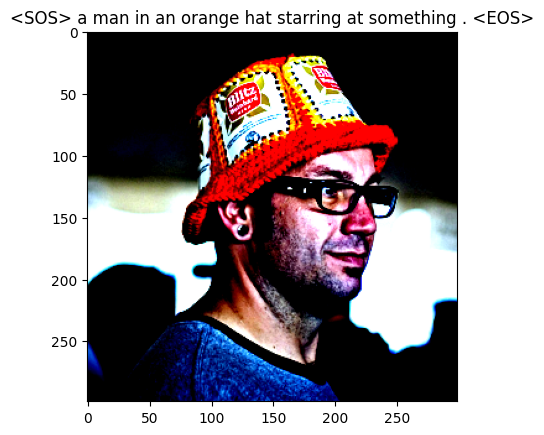

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


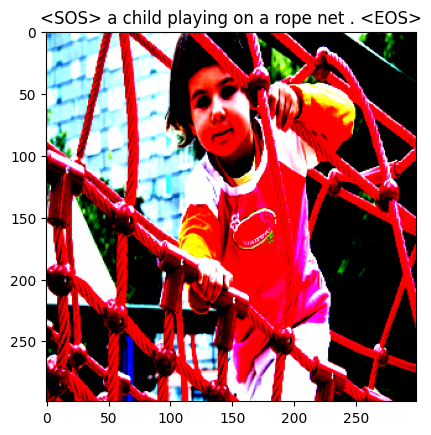

In [4]:
for i, (image, label) in enumerate(train_dataset):
    # only plot one example for each caption
    if i % 5 == 0:
        plt.imshow(image.permute(1,2,0))
        plt.title(" ".join([train_dataset.vocab.itos[idx.item()] for idx in label]))
        plt.show()
    # break after 25 iterations
    if i == 25:
        break

In [5]:
#Hyperparams
embed_size = 256
hidden_size = 256
vocab_size = len(train_dataset.vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 100

In [6]:
train = False
    criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
    ic_model = CNN2RNN(embed_size, hidden_size, vocab_size, num_layers)
    model = ImageCaptioner(ic_model, train_dataset, criterion)
    model.configure_optimizers(learning_rate)
    logger = TensorBoardLogger("lightning_logs", name="image_captioning")
    trainer = L.Trainer(max_epochs=num_epochs, 
                        fast_dev_run=False)

    # train the model
    trainer.fit(model, train_dataloaders=train_loader)
    # save best model
    trainer.save_checkpoint("best_model_image_captioning.ckpt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024-05-06 06:48:26.029715: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 06:48:26.076328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | CNNtoRNN  | CNN2RNN          | 27.7 M
1 | criterion | CrossEntropyLoss | 0     
-----

Epoch 99: 100%|██████████| 1265/1265 [02:21<00:00,  8.93it/s, v_num=13, Traning loss=2.030]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1265/1265 [02:22<00:00,  8.90it/s, v_num=13, Traning loss=2.030]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Example 1 CORRECT: Dog on a beach by the ocean


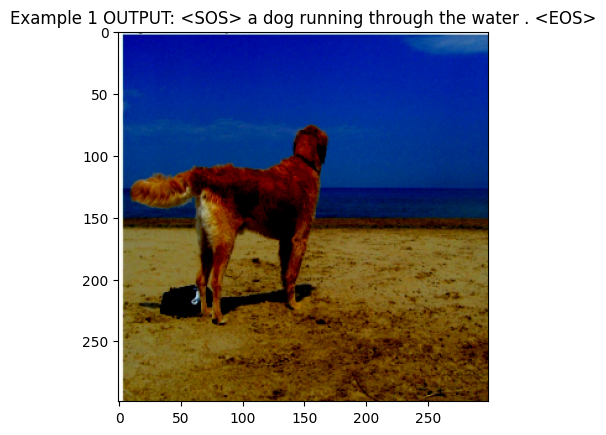

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Example 2 CORRECT: Child holding red frisbee outdoors


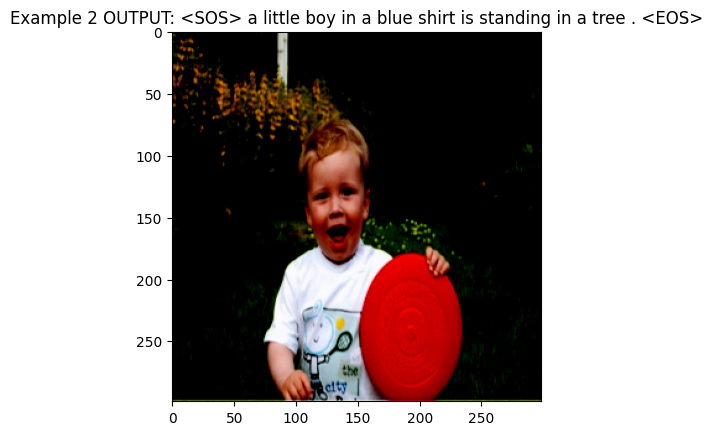

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Example 3 CORRECT: Bus driving by parked cars


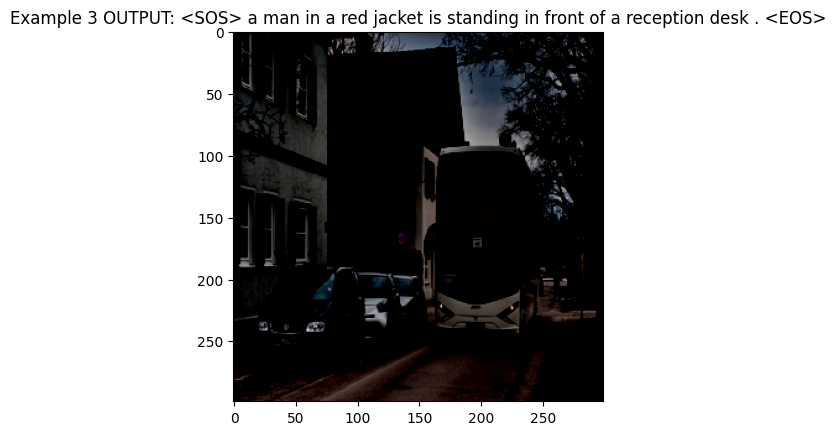

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Example 4 CORRECT: A small boat in the ocean


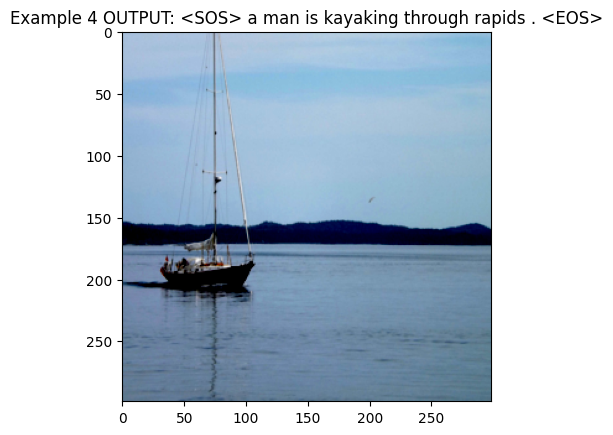

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Example 5 CORRECT: A cowboy riding a horse in the desert


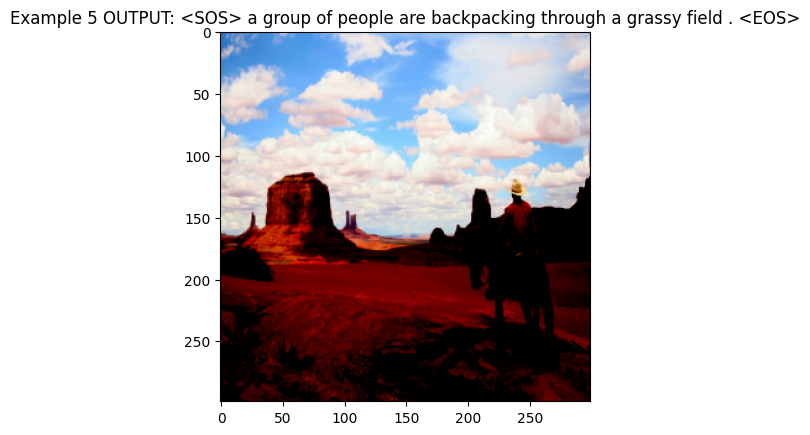

In [6]:
#model = CNN2RNN(embed_size, hidden_size, vocab_size, num_layers, learning_rate, criterion)
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
ic_model = CNN2RNN(embed_size, hidden_size, vocab_size, num_layers)
model = ImageCaptioner.load_from_checkpoint("best_model_image_captioning.ckpt",ic_model = ic_model,dataset = train_dataset, criterion = criterion)

# disable randomness, dropout, etc...
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print_examples(model, device, train_dataset)